In [1]:
%load_ext autoreload
%autoreload 2

# Preparations

In [2]:
import mkl
mkl.set_num_threads(1)

testing = True # TODO: run in testing mode (fast)

In [3]:
# Need to run these scripts once in the beginning to prepare all ingredients for the analysis
# - this might take several minutes, so run these only if you haven't done so before.

# load IceCube's effective area and rotate it to approximate other detectors
## %run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
## %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
## %run ../../core/resolution.py 
#--renew_calc if you want to repeat the resolution generation (takes a few minutes)

# gather all ingredients and save them as unified 'mephistogram' data structure
## %run ../../core/prepare_histograms.py

# Imports

In [4]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib

plt = sns.mpl.pyplot
from matplotlib.colors import LogNorm
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from scipy.optimize import fmin_l_bfgs_b
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import poisson
from scipy.stats import chi2, norm, percentileofscore, gamma
from settings import LOCALPATH, BASEPATH, sigma3, sigma5, PHI_NGC, GAMMA_NGC, E0_NGC, LIVETIME
import settings as st
from likelihood import setup_multi_llh, ps_llh_multi, ps_llh_single
from tools import (
    array_source_interp,
    get_scaler,
    scaling_estimation,
)
from fluxes import PL_flux, PLcut_flux, model_flux
from tqdm import tqdm
from fluxes import kheirandish_src_flux, inoue_src_flux, ngc_cut_flux
from fluxes import ngc_flux, ngc_cut_flux

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Settings

In [5]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(
        LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"
    ),
    "improved-50": join(
        LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}

# plot settings for different detector_configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + IC-North",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "KM3NeT": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + KM3NeT",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [6]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
# print(aeff_2d.keys())
# print(aeff_2d["IceCube"])

# Atmospheric background


In [7]:
with open(join(LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))

Elementary arithmetic possible.
True


# Energy resolution function

In [8]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d["IceCube"], verbose=True, raise_err=False))
energy_reso = {"baseline": baseline_eres, "improved": improved_eres} # easy access

Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (100, 140);
False


# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [11]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

# NGC1068 source parameters

In [12]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1e11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(LOCALPATH, "tenyr_paper_68_contour.txt")
)


In [13]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = st.ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = st.ngc1068.dec.rad

## Check event numbers

In [14]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~87

ngc 1068: 98.21015338126362


# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know

--> Imported from likelihood.py


# NGC 1068
## Significance test Background vs. Background + Signal

In [15]:
detector_keys = ["IceCube"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        eres=baseline_eres,
        conf=conf,
        aeff_2d=aeff_2d,
        src_flux=ngc_flux,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Atmo-only normalization: [1.06720859]
Signal fit parameters: [1.  1.  3.2]
TS check: -303610.6245645325 (fit:  -303610.6245645325 )
-2 Delta LLH: 22.14988576772157
P-VALUE: 1.5495779152563076e-05 SIGNIFICANCE: 4.166055279150261



# Combined model plot

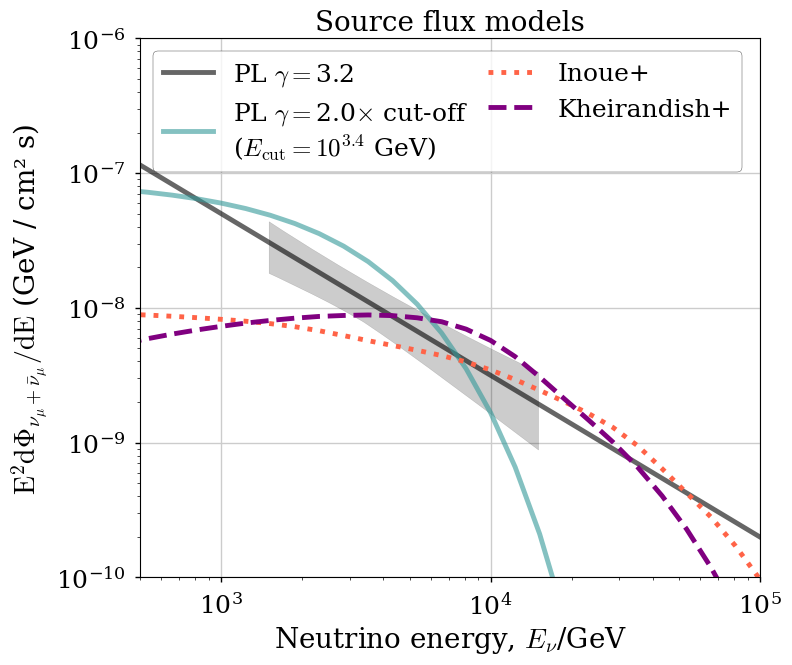

In [16]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

#pl = power_law(x_evals, ngc_pl0_flux.E0, ngc_pl0_flux.gamma, ngc_pl0_flux.norm)
pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

f, ax = plt.subplots(figsize=(8, 7))
fontsize = 20
ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"PL $\gamma=${GAMMA_NGC}",
    color="k",
    alpha=0.6,
    lw=3.5,
)

ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
    label=rf"PL $\gamma=${st.Gamma_cut}"
    + rf"$\times$ cut-off "
    + "\n"
    + rf"($E_{{\rm cut}}=10^{{{st.logE_cut:1.1f}}}$ GeV)",
    color="#339999",
    alpha=0.6,
    lw=3.5,
)
# ax.plot(
#     10 ** aeff_factor_signal.bin_mids[1],
#     array_source_interp(
#         ngc_src_config["dec"],
#         bckg_histo["IceCube"],
#         bckg_histo["IceCube"].bin_mids[0],
#         axis=1,
#     )
#     * sq_deg
#     * (10 ** aeff_factor_signal.bin_mids[1]) ** y_scaling,
#     label=r"Atmospheric $\nu_\mu$ background",
#     color="gray",
#     lw=3,
# )

ax.set_yscale("log")
ax.set_ylabel(
    r"$\rm E^2 d\Phi_{\nu_\mu + \bar{\nu}_\mu} / dE$ (GeV / cm² s)", fontsize=fontsize
)
ax.set_xscale("log")
ax.set_xlabel(r"Neutrino energy, $E_{\nu}$/GeV", fontsize=fontsize)
ax.set_ylim(1e-10, 1e-6)
ax.set_xlim(5e2, 1e5)


ax.plot(
    x_evals, 
    10**(inoue_src_flux.model_spline(np.log10(x_evals))) * (x_evals**y_scaling),
    color="tomato",
    ls=":",
    label="Inoue+",
    lw=3.5,
)

ax.plot(
    x_evals, 
    10**(kheirandish_src_flux.model_spline(np.log10(x_evals))) * (x_evals**y_scaling),
    color="purple",
    ls="--",
    label="Kheirandish+",
    lw=3.5,
)

ax.legend(
    frameon=True,
    loc="upper left",
    ncols=2,
    bbox_to_anchor=(0, 1.0),
    columnspacing=0.8,
    edgecolor="k",
)

f.savefig(join(BASEPATH, "plots/ngc_paper/model_source_fluxes.pdf"), bbox_inches="tight")

# Model fit disk corona Kheirandish

## combined plot

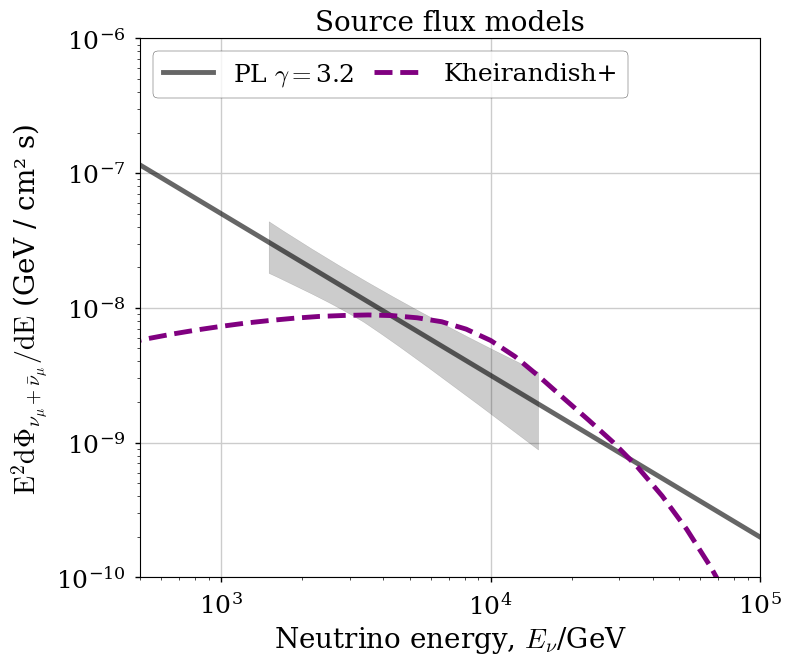

In [17]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)

f, ax = plt.subplots(figsize=(8, 7))
fontsize = 20
ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"PL $\gamma=${GAMMA_NGC}",
    color="k",
    alpha=0.6,
    lw=3.5,
)

ax.set_yscale("log")
ax.set_ylabel(
    r"$\rm E^2 d\Phi_{\nu_\mu + \bar{\nu}_\mu} / dE$ (GeV / cm² s)", fontsize=fontsize
)
ax.set_xscale("log")
ax.set_xlabel(r"Neutrino energy, $E_{\nu}$/GeV", fontsize=fontsize)
ax.set_ylim(1e-10, 1e-6)
ax.set_xlim(5e2, 1e5)


ax.plot(
    x_evals, 
    10**(kheirandish_src_flux.model_spline(np.log10(x_evals))) * (x_evals**y_scaling),
    color="purple",
    ls="--",
    label="Kheirandish+",
    lw=3.5,
)

ax.legend(
    frameon=True,
    loc="upper left",
    ncols=2,
    bbox_to_anchor=(0, 1.0),
    columnspacing=0.8,
    edgecolor="k",
)


## event numbers

In [18]:
aeff_factor_signal = calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=improved_eres,
    phi_scaling=1,
    flux_shape=kheirandish_src_flux,
)
print(np.sum(k_s))

39.581701906880134


## model fit

In [19]:
## direct fit of kheirandish model (normalization only)

detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        improved_eres,
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux=kheirandish_src_flux,
    )

    dct = dict(
        shape="model_flux",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=None,  # parameter not used
        phi_0=None,  # parameter not used
        flux_shape=kheirandish_src_flux,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.1, 1.1),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    ts_check = global_llh((1, 1))
    print(f"TS check: {ts_check}, fit: {out_comp[1]}, diff: {ts_check - out_comp[1]}")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print(
        "Check P-VALUE:",
        chi2.sf(out_bckg[1] - ts_check, 1),
        "SIGNIFICANCE:",
        norm.isf(chi2.sf(out_bckg[1] - ts_check, 1)),
    )
    print()

IceCube
Atmo-only normalization: [1.02709155]
Signal fit parameters: [0.99999807 0.99999486]
TS check: -283070.81943585287, fit: -283070.8194358467, diff: -6.170012056827545e-09
-2 Delta LLH: 15.22229894757038
P-VALUE: 9.556826122717755e-05 SIGNIFICANCE: 3.730452045353768
Check P-VALUE: 9.556826091494653e-05 SIGNIFICANCE: 3.7304520461768558

Plenum-1
Atmo-only normalization: [1.03400125]
Signal fit parameters: [1.00005231 0.99948267]
TS check: -1284333.5107058329, fit: -1284333.510687301, diff: -1.85319222509861e-05
-2 Delta LLH: 79.72688717767596
P-VALUE: 4.2991034201802606e-19 SIGNIFICANCE: 8.851977460498752
Check P-VALUE: 4.2990630972101783e-19 SIGNIFICANCE: 8.851978507049926

Plenum-2
Atmo-only normalization: [1.029308]
Signal fit parameters: [1.00002357 0.99972528]
TS check: -1239081.119514499, fit: -1239081.1195023884, diff: -1.2110685929656029e-05
-2 Delta LLH: 178.81314995884895
P-VALUE: 8.801617057422569e-41 SIGNIFICANCE: 13.320454603881702
Check P-VALUE: 8.801563465961356e-41

## fit PL

In [20]:
kheirandish_flux_exp = model_flux(
    norm=kheirandish_src_flux.norm * 1.5,
    model_spline=kheirandish_src_flux.model_spline,
    shape=kheirandish_src_flux.shape,
)

In [21]:
## powerlaw fit of kheirandish model
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        improved_eres,
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux=kheirandish_flux_exp, # we use here the larger flux we fit in experimental data
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_pl_kheirandish = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_pl_kheirandish[0])
    print(
        "TS check:",
        global_llh((1, 1, ngc_flux.gamma)),
        "(fit: ",
        out_pl_kheirandish[1],
        ")",
    )
    print("-2 Delta LLH:", out_bckg[1] - out_pl_kheirandish[1])

    pval = chi2.sf(out_bckg[1] - out_pl_kheirandish[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Atmo-only normalization: [1.04063246]
Signal fit parameters: [0.99155405 0.56769179 2.79972122]
TS check: -282813.4210084418 (fit:  -282819.96681336965 )
-2 Delta LLH: 27.846103456569836
P-VALUE: 8.98039549113518e-07 SIGNIFICANCE: 4.775111278640733

Plenum-1
Atmo-only normalization: [1.05099698]
Signal fit parameters: [0.99014839 0.51072836 2.74168631]
TS check: -1282609.4275692736 (fit:  -1282650.7796131503 )
-2 Delta LLH: 144.18539271131158
P-VALUE: 4.9038794686141424e-32 SIGNIFICANCE: 11.7222116305271

Plenum-2
Atmo-only normalization: [1.04395892]
Signal fit parameters: [0.99127877 0.54172136 2.77568305]
TS check: -1237296.8616894349 (fit:  -1237380.42669535 )
-2 Delta LLH: 325.16366722714156
P-VALUE: 2.463807675884127e-71 SIGNIFICANCE: 17.82018175276695



In [22]:
# (approximate) PL result if truth is DC model
ngc_pl0_flux = PL_flux(
    PHI_NGC * out_pl_kheirandish[0][1], out_pl_kheirandish[0][2], E0_NGC, "powerlaw"
)

## estimate significance vs. PL 
based on PEs and tuned to experimental data (as comparison on what significance to expect)

In [23]:
# generic source config without dec coordinate
exp_src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=st.LIVETIME, # st.LIVETIME_86
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
exp_bg_config = copy(exp_src_config)
exp_bg_config["dpsi_max"] = st.delta_psi_max
exp_bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
exp_ngc_src_config = copy(exp_src_config)
exp_ngc_src_config["dec"] = st.ngc1068.dec.rad
exp_ngc_bg_config = copy(exp_bg_config)
exp_ngc_bg_config["dec"] = st.ngc1068.dec.rad

IceCube
Atmo-only normalization: [1.04063316]
out_DC (array([0.9999901, 1.5000665]), -282822.67865268793)
out_PL (array([0.9915149 , 1.04666704, 2.79912559]), -282819.9668003285)
P-VALUE: 3.24042525019654e-08 SIGNIFICANCE: 5.404999690067305


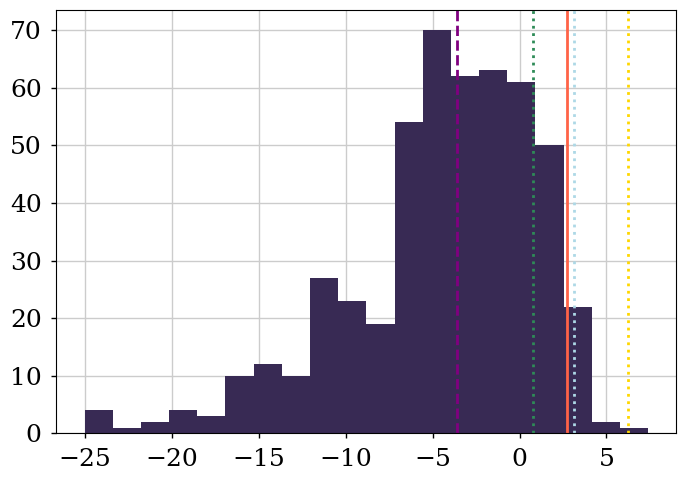

Plenum-1
Atmo-only normalization: [1.04063507]
out_DC (array([0.99998394, 1.50027766]), -261144.50057931303)
out_PL (array([0.99147906, 1.0474356 , 2.79926452]), -261139.07687102395)
P-VALUE: 5.381221690129095e-15 SIGNIFICANCE: 7.7299078825659375


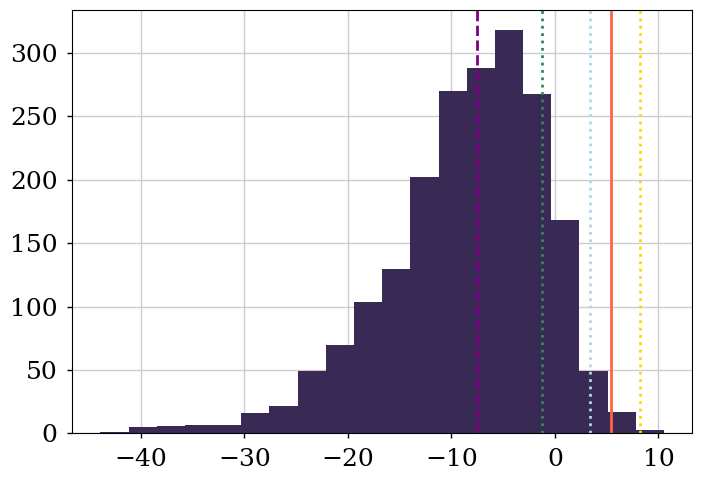

Plenum-2
Atmo-only normalization: [1.04063528]
out_DC (array([0.99998559, 1.50018779]), -215892.10938578856)
out_PL (array([0.99155347, 1.04762624, 2.79961847]), -215869.05875721938)
P-VALUE: 1.9527322301015226e-58 SIGNIFICANCE: 16.073627694985486


In [24]:
detector_keys = {"IceCube": 500, "Plenum-1": 2000, "Plenum-2": 7000}
#detector_keys = {"IceCube": 30, "Plenum-1": 30, "Plenum-2": 30}
for key in detector_keys:

    conf = st.detector_configurations[key]
    print(key)
    # baseline fit of kheirandish model as reference for test
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        improved_eres,  # predict sensitivity for exp. data
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=exp_ngc_bg_config,
        sig_config=exp_ngc_src_config,
        src_flux=kheirandish_flux_exp,  # signal hypothesis
        return_s_b=True,
    )

    dct = dict(
        aeff_factor_s=all_aeff_factor_s[0],
        aeff_factor_b=all_aeff_factor_b[0],
        k_i=all_k[0],
        bckg_flux=all_bckg_flux[0],
        energy_resolution=all_eres[0],
        e_0=ngc_pl0_flux.E0,
        phi_0=ngc_pl0_flux.norm,
    )

    # baseline asimov expectation
    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_single(
        (x[0], 0), shape="model_flux", flux_shape=kheirandish_src_flux, **dct
    )
    global_llh = lambda x: ps_llh_single(
        x, shape="model_flux", flux_shape=kheirandish_src_flux, **dct
    )
    ps_llh = lambda x: ps_llh_single(x, shape="powerlaw", flux_shape=ngc_pl0_flux, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_DC = fmin_l_bfgs_b(
        global_llh,
        x0=(1.1, 1.1),
        approx_grad=True,
    )
    print("out_DC", out_DC[:2])
    out_PL = fmin_l_bfgs_b(
        ps_llh,
        x0=(1.1, 0.3, 2.8),
        approx_grad=True,
    )
    print("out_PL", out_PL[:2])

    pval = chi2.sf(out_bckg[1] - out_DC[1], 1)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)


    # adapted powerlaw as null hypothesis
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        improved_eres,  # predict sensitivity for exp. data
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=exp_ngc_bg_config,
        sig_config=exp_ngc_src_config,
        src_flux=ngc_pl0_flux,  # null hypothesis
    )

    dct = dict(
        aeff_factor_s=all_aeff_factor_s[0],
        aeff_factor_b=all_aeff_factor_b[0],
        bckg_flux=all_bckg_flux[0],
        energy_resolution=all_eres[0],
        e_0=ngc_pl0_flux.E0,
        phi_0=ngc_pl0_flux.norm,
    )

    TS_pl_as_H0_kh = []

    for i in range(detector_keys[key]):
        PE = poisson.rvs(all_k[0].histo)
        # full optimization of all parameters of PL model
        pl_llh = lambda x: ps_llh_single(x, k_i=PE, shape="powerlaw", **dct)
        # S+B fit
        out_pl_pe = fmin_l_bfgs_b(
            pl_llh,
            x0=(1, 1, ngc_pl0_flux.gamma),
            bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
            approx_grad=True,
        )

        model_llh = lambda x: ps_llh_single(
            x, k_i=PE, shape="model_flux", flux_shape=kheirandish_flux_exp, **dct
        )

        # S+B fit
        out_kheirandish_pe = fmin_l_bfgs_b(
            model_llh,
            x0=(1.2, 1.1),
            bounds=[(1e-3, 10), (1e-3, 100)],
            approx_grad=True,
        )

        TS_pl_as_H0_kh.append(
            {
                "TS": out_pl_pe[1] - out_kheirandish_pe[1],
                "pl_bg_norm": out_pl_pe[0][0],
                "pl_norm": out_pl_pe[0][1],
                "pl_gamma": out_pl_pe[0][2],
                "model_bg": out_kheirandish_pe[0][0],
                "model_norm": out_kheirandish_pe[0][1],
                "quality": out_kheirandish_pe[2]["warnflag"] + out_pl_pe[2]["warnflag"],
            }
        )
    TS_pl_as_H0_kh = pd.DataFrame(TS_pl_as_H0_kh)
    plt.figure()
    plt.hist(TS_pl_as_H0_kh.TS, bins=20)
    plt.axvline(out_PL[1] - out_DC[1], color="tomato")
    plt.axvline(np.median(TS_pl_as_H0_kh.TS), color="purple", ls="--")
    plt.axvline(np.quantile(TS_pl_as_H0_kh.TS, norm.cdf(1)), color="seagreen", ls=":")
    plt.axvline(np.quantile(TS_pl_as_H0_kh.TS, norm.cdf(2)), color="lightblue", ls=":")
    plt.axvline(np.quantile(TS_pl_as_H0_kh.TS, norm.cdf(3)), color="gold", ls=":")
    plt.show()

# 2D contour of model fit with PL
## DC and TW model

In [ ]:
contour_formats = {
    "IceCube": {"colors": [st.poles["IceCube"]["color"]], "linestyles": "--"},
    "P-ONE": {"colors": [st.poles["P-ONE"]["color"]], "linestyles": ":"},
    "Plenum-1": {
        "colors": [st.poles["Plenum-1"]["color"]],
        "linestyles": st.poles["Plenum-1"]["ls"],
    },
    "Plenum-2": {
        "colors": [st.poles["Plenum-2"]["color"]],
        "linestyles": st.poles["Plenum-2"]["ls"],
    },
}
detector_keys = ["IceCube"] #, "P-ONE", "Plenum-1", "Plenum-2"]
for key, eres_key in product(detector_keys, energy_reso):
    conf = st.detector_configurations[key]
    print(key, conf, eres_key)

IceCube (['IceCube'], [1]) baseline


In [ ]:
energy_reso = {"baseline": baseline_eres} #, "improved": improved_eres}
src_models = {"kheirandish": kheirandish_src_flux, "inoue": inoue_src_flux}
step = 0.1
gamma_astro = np.arange(2.2, 4, step=step)
astro_scaling = np.logspace(-1, 0.5, num=10)
if True:
    tmp_SPL = []

    # loop over detector_configurations and energy resolutions
    for ident, eres_key, model_key in product(detector_keys, energy_reso, src_models):
        conf = st.detector_configurations[ident]
        print("info:", ident, conf, eres_key)
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
        ) = setup_multi_llh(
            eres=energy_reso[eres_key],  # select one resolution for all data sets
            conf=conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=ngc_bg_config,
            sig_config=ngc_src_config,
            src_flux=src_models[model_key]
        )

        dct = dict(
            shape="powerlaw",
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm
        )

        global_llh = lambda x: ps_llh_multi(x, **dct)
        out = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, ngc_flux.gamma),
            approx_grad=True,
        )

        if out[2]["warnflag"] != 0:
            print("WARNING!!")
            print("bf param:", out[0])

        tmp = dict()
        tmp["LLH"] = "global"
        tmp["energy_res"] = eres_key
        tmp["ident"] = ident

        tmp["ts"] = out[1]
        tmp["conv"] = out[0][0]
        tmp["phi_astro"] = out[0][1]
        tmp["gamma"] = out[0][2]
        tmp["model"] = model_key
        tmp_SPL.append(tmp)

        print("starting local fits...")
        for jj, (aa, gg) in enumerate(product(astro_scaling, gamma_astro)):
            # if jj%int(len(astro_scaling) * len(gamma_astro)/5) == 0: print("it", jj)
            # local min with fixed phi_astro
            local_llh = lambda x: ps_llh_multi((x[0], aa, gg), **dct)
            local_out = fmin_l_bfgs_b(local_llh, x0=[1], approx_grad=True, maxls=35)
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])

            tmp = dict()
            tmp["LLH"] = "local"
            tmp["energy_res"] = eres_key
            tmp["ident"] = ident

            tmp["ts"] = local_out[1]
            tmp["delta_ts"] = local_out[1] - out[1]
            tmp["conv"] = local_out[0][0]
            tmp["phi_astro"] = aa
            tmp["gamma"] = gg
            tmp["model"] = model_key
            tmp_SPL.append(tmp)
    print("done")

    SPL_df = pd.DataFrame(tmp_SPL)

info: IceCube (['IceCube'], [1]) baseline
starting local fits...
info: IceCube (['IceCube'], [1]) baseline
starting local fits...
done


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


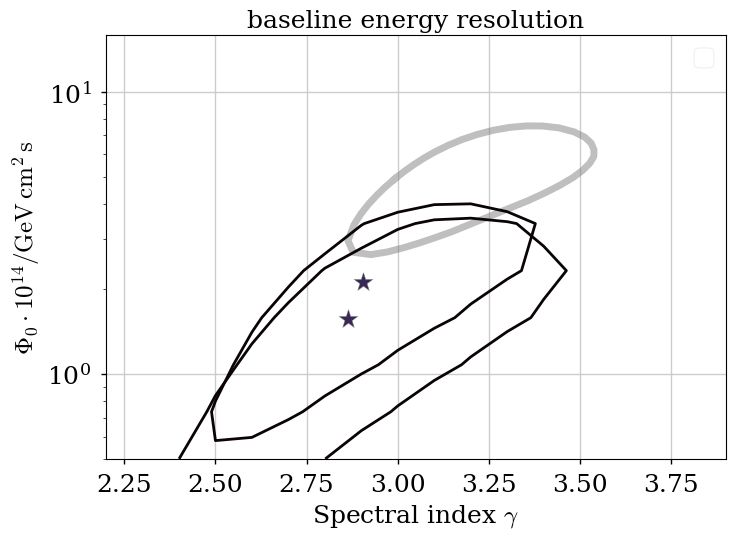

In [ ]:
ref_color = "gray"

f, ax = plt.subplots()
eres_key = "baseline"
ax.plot(
    gamma_c_68,
    phi_c_68 * 1e11,
    color=ref_color,
    ls="-",
    lw=5,
    alpha=0.5,
)

# draw contour levels
cvals = [0.32]
lbs = ["68%"]
levels = chi2.isf(cvals, 2)

res_local = SPL_df.loc[(SPL_df.LLH == "local") & (SPL_df.energy_res == eres_key)]
res_global = SPL_df.loc[(SPL_df.LLH == "global") & (SPL_df.energy_res == eres_key)]

for (ident, model_key), series in res_local.groupby(["ident", "model"]):
    local_pivot = series.pivot(index="gamma", columns="phi_astro", values="delta_ts")
    sc = ax.contour(
        local_pivot.index,
        local_pivot.columns * ngc_flux.norm * 1e14,
        local_pivot.T,
        levels=levels,
        lw=3,
        label=model_key
    )
# best fit
ax.scatter(
    res_global.gamma.unique(),
    res_global.phi_astro.unique() * ngc_flux.norm * 1e14,
    marker="*",
    s=200,
    edgecolor=ref_color,
    )

# ax.set_ylim(2, 8)
# ax.set_xlim(2.8, 3.8)
ax.set_ylabel(r"$\Phi_0 \cdot 10^{14} / {\rm GeV\, cm^2\, s}$")
ax.set_title(f"{eres_key} energy resolution")
ax.set_yscale("log")
ax.set_xlabel(r"Spectral index $\gamma$")
ax.legend()

# fit mixture model

In [ ]:
ident="IceCube"
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s_kh = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=improved_eres,
    phi_scaling=1,
    flux_shape=kheirandish_src_flux,
)

print(k_s_kh.sum())
k_s_pl = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print(k_s_pl.sum())
diff = k_s_pl.sum() - k_s_kh.sum()
print("diff", diff)
factor = diff/ k_s_pl.sum()
print(factor)

ngc_PL_mixture = PL_flux(
    ngc_flux.norm * factor, # * 1.1, 
    ngc_flux.gamma, 
    ngc_flux.E0, 
    ngc_flux.shape
)

# roughly yields same number of events in the end

k_s_pl_mix = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_PL_mixture,
)
print(k_s_pl_mix.sum())
print()



39.581701906880134
98.21015338126362
diff 58.62845147438349
0.5969693504782626
58.62845147438348



(2.0, 6.0)

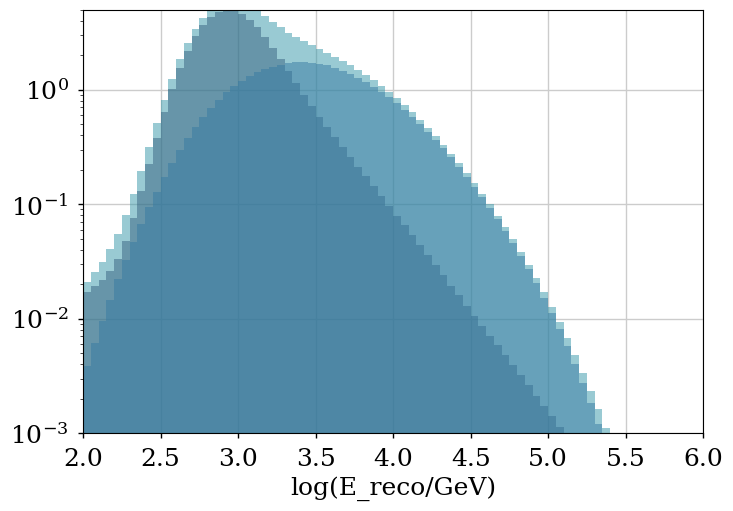

In [ ]:
f, ax = plt.subplots()
k_s_pl_mix.sum(axis=0, return_mephisto=True).plot(f=f, ax=ax, alpha=0.5)
k_s_kh.sum(axis=0, return_mephisto=True).plot(f=f, ax=ax, alpha=0.5)
(k_s_pl_mix + k_s_kh).sum(axis=0, return_mephisto=True).plot(f=f, ax=ax, alpha=0.5)


plt.yscale("log")
plt.ylim(1e-3, 5)
plt.xlim(2, 6)

In [ ]:
## fit model + powerlaw mixture model

detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        improved_eres,
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux=[kheirandish_src_flux, ngc_PL_mixture],
    )

    dct = dict(
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=st.E0_NGC,  # parameter not used
        phi_0=st.PHI_NGC,  # parameter not used
        flux_shape=kheirandish_src_flux,
        shape=["model_flux", "powerlaw"],
        signal_parameters=[1, 2],  # for each of the models
    )

    # fix signal normalization to 0
    ndof = 3  # for p-value calculation
    local_llh = lambda x: ps_llh_multi((x[0], 0, 0, 2), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.1,),
        bounds=[
            (1e-3, 10),
        ],
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.1, 1.1, 1.1, 3.3),
        bounds=[
            (1e-3, 10),
            (1e-3, 10),
            (1e-3, 10),
            (1e-3, 10),
        ],
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    ts_check = global_llh((1, 1, 1, st.GAMMA_NGC))
    print(f"TS check: {ts_check}, fit: {out_comp[1]}, diff: {ts_check - out_comp[1]}")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], ndof)
    significance = norm.isf(pval)
    print("mixture model vs atmo: P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print(
        "Check P-VALUE:",
        chi2.sf(out_bckg[1] - ts_check, ndof),
        "SIGNIFICANCE:",
        norm.isf(chi2.sf(out_bckg[1] - ts_check, ndof)),
    )

    # fitting with PL
    dct = dict(
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=st.E0_NGC,  # parameter not used
        phi_0=st.PHI_NGC,  # parameter not used
        shape="powerlaw",
    )
    ndof = 1
    PL_global_llh = lambda x: ps_llh_multi(x, **dct)
    out_PL_global = fmin_l_bfgs_b(
        PL_global_llh,
        x0=(1.1, 1.1, 3.3),
        bounds=[
            (1e-3, 10),
            (1e-3, 10),
            (1e-3, 10),
        ],
        approx_grad=True,
    )
    print(" PL fit on mixture model:")
    print("Signal fit parameters:", out_PL_global[0])
    pval = chi2.sf(out_comp[1] - out_PL_global[1], ndof)
    significance = norm.isf(pval)
    print("mixture model vs pure PL: P-VALUE:", pval, "SIGNIFICANCE:", significance)

    print()


IceCube
Atmo-only normalization: [1.06721666]
Signal fit parameters: [0.99962538 0.85662282 0.64630382 3.13831855]
TS check: -279345.09311528143, fit: -279348.0267776681, diff: 2.9336623866693117
-2 Delta LLH: 37.41414921119576
mixture model vs atmo: P-VALUE: 3.760566634663058e-08 SIGNIFICANCE: 5.37825478025078
Check P-VALUE: 1.5684561218059732e-07 SIGNIFICANCE: 5.115029922591094
 PL fit on mixture model:
Signal fit parameters: [0.99769981 0.92926676 2.96029916]
mixture model vs pure PL: P-VALUE: 1.0 SIGNIFICANCE: -inf

Plenum-1
Atmo-only normalization: [1.08907476]
Signal fit parameters: [0.99999864 0.98227577 0.59666334 3.18495672]
TS check: -1264655.6461442262, fit: -1264671.1269028266, diff: 15.480758600402623
-2 Delta LLH: 196.76744634332135
mixture model vs atmo: P-VALUE: 2.106682878030161e-42 SIGNIFICANCE: 13.596277904511231
Check P-VALUE: 4.651521823355628e-39 SIGNIFICANCE: 13.020930377739935
 PL fit on mixture model:
Signal fit parameters: [0.9978793  0.90580875 2.9396864 ]
mi

# model fit inoue

## event numbers

In [ ]:
aeff_factor_signal = calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=improved_eres,
    phi_scaling=1,
    flux_shape=inoue_src_flux,
)
print(np.sum(k_s))

27.753064487295198


## model fit

In [ ]:
## direct fit of inoue_src_flux model (normalization only)

detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        improved_eres,
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux=inoue_src_flux,
    )

    dct = dict(
        shape="model_flux",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=None,  # parameter not used
        phi_0=None,  # parameter not used
        flux_shape=inoue_src_flux,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.1, 1.1),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    ts_check = global_llh((1, 1))
    print(f"TS check: {ts_check}, fit: {out_comp[1]}, diff: {ts_check - out_comp[1]}")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print(
        "Check P-VALUE:",
        chi2.sf(out_bckg[1] - ts_check, 1),
        "SIGNIFICANCE:",
        norm.isf(chi2.sf(out_bckg[1] - ts_check, 1)),
    )

    # # pL fit:    
    # dct = dict(
    #     shape="powerlaw",
    #     all_aeff_factor_s=all_aeff_factor_s,
    #     all_aeff_factor_b=all_aeff_factor_b,
    #     all_k=all_k,
    #     all_bckg_flux=all_bckg_flux,
    #     all_eres=all_eres,
    #     e_0=ngc_flux.E0,  # parameter not used
    #     phi_0=ngc_flux.norm,  # parameter not used
    # )
    # ps_llh = lambda x: ps_llh_multi(x, **dct)

    # out_pl_inoue = fmin_l_bfgs_b(
    #     ps_llh,
    #     x0=(1.1, 1.1, 2.8),
    #     approx_grad=True,
    # )
    # print("PL on inoue exp model:", out_pl_inoue[0])
    print()

IceCube
Atmo-only normalization: [1.0213223]
Signal fit parameters: [0.99830421 1.09702811]
TS check: -286629.24467799877, fit: -286629.1950172082, diff: -0.04966079053701833
-2 Delta LLH: 8.489405084284954
P-VALUE: 0.0035722059615500164 SIGNIFICANCE: 2.690036897562082
Check P-VALUE: 0.0034760397822399215 SIGNIFICANCE: 2.6991310425190855
PL on inoue exp model: [0.99584949 0.29729542 2.80858917]

Plenum-1
Atmo-only normalization: [1.02687521]
Signal fit parameters: [1.00011011 0.99869228]
TS check: -1298388.6098537692, fit: -1298388.609783527, diff: -7.024221122264862e-05
-2 Delta LLH: 44.41692548338324
P-VALUE: 2.653827713350917e-11 SIGNIFICANCE: 6.5620400508031365
Check P-VALUE: 2.6537324965962006e-11 SIGNIFICANCE: 6.562045399541938
PL on inoue exp model: [0.99529808 0.27013165 2.75988165]

Plenum-2
Atmo-only normalization: [1.02310363]
Signal fit parameters: [1.00000396 0.99974255]
TS check: -1253136.2186624357, fit: -1253136.21865842, diff: -4.0156301110982895e-06
-2 Delta LLH: 100.

## fit PL

In [ ]:
inoue_flux_exp = model_flux(
    inoue_src_flux.norm * 1.9, inoue_src_flux.model_spline, inoue_src_flux.shape
)

In [ ]:
## powerlaw fit of inoue_src_flux model
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        improved_eres,
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux=inoue_flux_exp,
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_pl_inoue = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_pl_inoue[0])
    print(
        "TS check:",
        global_llh((1, 1, ngc_flux.gamma)),
        "(fit: ",
        out_pl_inoue[1],
        ")",
    )
    print("-2 Delta LLH:", out_bckg[1] - out_pl_inoue[1])

    pval = chi2.sf(out_bckg[1] - out_pl_inoue[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Atmo-only normalization: [1.04050814]
Signal fit parameters: [0.99366418 0.52826269 2.7779077 ]
TS check: -286163.1838799722 (fit:  -286169.1664579057 )
-2 Delta LLH: 24.604350685840473
P-VALUE: 4.541853619879002e-06 SIGNIFICANCE: 4.437908840482571

Plenum-1
Atmo-only normalization: [1.05106111]
Signal fit parameters: [0.9928956  0.4822294  2.73077818]
TS check: -1295277.6851310125 (fit:  -1295313.7776445905 )
-2 Delta LLH: 124.43060377752408
P-VALUE: 9.555154193900512e-28 SIGNIFICANCE: 10.853895509632194

Plenum-2
Atmo-only normalization: [1.04389309]
Signal fit parameters: [0.9935672  0.5073671  2.75842731]
TS check: -1249978.7481448485 (fit:  -1250053.553295558 )
-2 Delta LLH: 284.4742020324338
P-VALUE: 1.6873761515782403e-62 SIGNIFICANCE: 16.64347117873714



In [ ]:
# (approximate) PL result if truth is DC model
ngc_pl_inoue_flux = PL_flux(
    PHI_NGC * out_pl_inoue[0][1], out_pl_inoue[0][2], E0_NGC, "powerlaw"
)

## inoue vs PL

IceCube
Atmo-only normalization: [1.04051072]
out_TW (array([1.00000038, 0.99998664]), -286170.34477148205)
out_PL (array([0.99367354, 1.04205586, 2.77823822]), -286169.16645341954)
P-VALUE: 3.821051176895187e-07 SIGNIFICANCE: 4.944292159005091


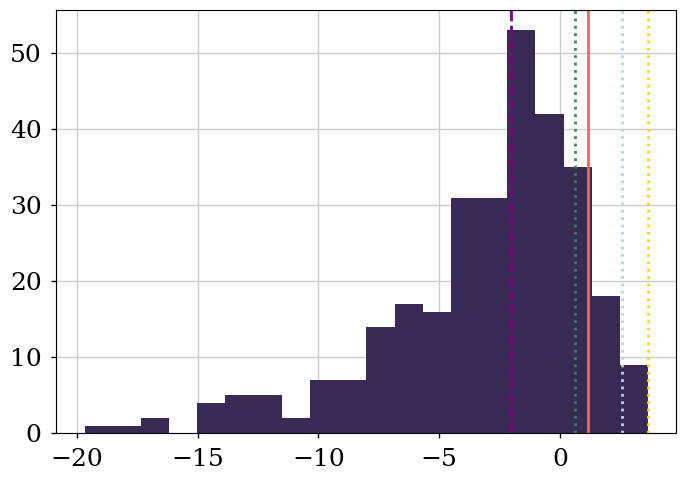

Plenum-1
Atmo-only normalization: [1.04050904]
out_TW (array([1.00000046, 1.00002273]), -264492.1666994543)
out_PL (array([0.99368028, 1.0417089 , 2.77808302]), -264489.81006807135)
P-VALUE: 6.925386459211934e-13 SIGNIFICANCE: 7.085535427908413


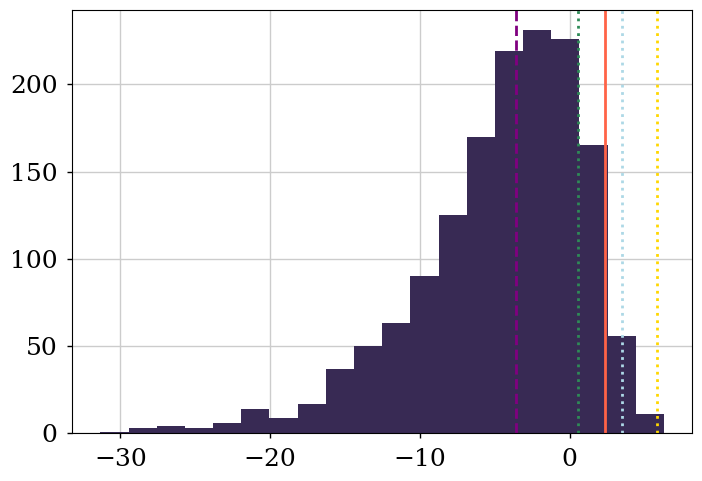

Plenum-2
Atmo-only normalization: [1.04050825]
out_TW (array([1.        , 1.00000414]), -219239.77550813646)
out_PL (array([0.99369409, 1.04116535, 2.77791554]), -219229.75983553648)
P-VALUE: 1.384250333547637e-49 SIGNIFICANCE: 14.757120734789806


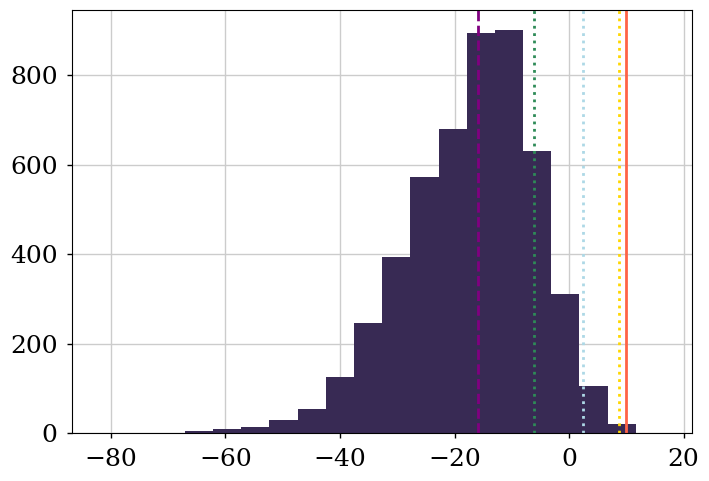

In [ ]:
detector_keys = {"IceCube": 300, "Plenum-1": 1500, "Plenum-2": 5000}
#detector_keys = {"IceCube": 30, "Plenum-1": 30, "Plenum-2": 30}
for key in detector_keys:

    conf = st.detector_configurations[key]
    print(key)
    # baseline fit of inoue model as reference for test
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        improved_eres,  # predict sensitivity for exp. data
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=exp_ngc_bg_config,
        sig_config=exp_ngc_src_config,
        src_flux=inoue_flux_exp,  # signal hypothesis
        return_s_b=True,
    )

    dct = dict(
        aeff_factor_s=all_aeff_factor_s[0],
        aeff_factor_b=all_aeff_factor_b[0],
        k_i=all_k[0],
        bckg_flux=all_bckg_flux[0],
        energy_resolution=all_eres[0],
        e_0=ngc_pl_inoue_flux.E0,
        phi_0=ngc_pl_inoue_flux.norm,
    )

    # baseline asimov expectation
    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_single(
        (x[0], 0), shape="model_flux", flux_shape=inoue_flux_exp, **dct
    )
    global_llh = lambda x: ps_llh_single(
        x, shape="model_flux", flux_shape=inoue_flux_exp, **dct
    )
    ps_llh = lambda x: ps_llh_single(
        x, shape="powerlaw", flux_shape=ngc_pl0_flux, **dct
    )

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_TW = fmin_l_bfgs_b(
        global_llh,
        x0=(1.1, 1.1),
        approx_grad=True,
    )
    print("out_TW", out_TW[:2])
    out_PL = fmin_l_bfgs_b(
        ps_llh,
        x0=(1.1, 0.3, 2.8),
        approx_grad=True,
    )
    print("out_PL", out_PL[:2])

    pval = chi2.sf(out_bckg[1] - out_TW[1], 1)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)

    # adapted powerlaw as null hypothesis
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        improved_eres,  # predict sensitivity for exp. data
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=exp_ngc_bg_config,
        sig_config=exp_ngc_src_config,
        src_flux=ngc_pl_inoue_flux,  # null hypothesis
    )

    dct = dict(
        aeff_factor_s=all_aeff_factor_s[0],
        aeff_factor_b=all_aeff_factor_b[0],
        bckg_flux=all_bckg_flux[0],
        energy_resolution=all_eres[0],
        e_0=ngc_pl_inoue_flux.E0,
        phi_0=ngc_pl_inoue_flux.norm,
    )

    TS_pl_as_H0_inoue = []

    for i in range(detector_keys[key]):
        PE = poisson.rvs(all_k[0].histo)
        # full optimization of all parameters of PL model
        pl_llh = lambda x: ps_llh_single(x, k_i=PE, shape="powerlaw", **dct)
        # S+B fit
        out_pl_pe = fmin_l_bfgs_b(
            pl_llh,
            x0=(1, 1, ngc_pl_inoue_flux.gamma),
            bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
            approx_grad=True,
        )

        model_llh = lambda x: ps_llh_single(
            x, k_i=PE, shape="model_flux", flux_shape=inoue_flux_exp, **dct
        )

        # S+B fit
        out_inoue_pe = fmin_l_bfgs_b(
            model_llh,
            x0=(1.2, 1.1),
            bounds=[(1e-3, 10), (1e-3, 100)],
            approx_grad=True,
        )

        TS_pl_as_H0_inoue.append(
            {
                "TS": out_pl_pe[1] - out_inoue_pe[1],
                "pl_bg_norm": out_pl_pe[0][0],
                "pl_norm": out_pl_pe[0][1],
                "pl_gamma": out_pl_pe[0][2],
                "model_bg": out_inoue_pe[0][0],
                "model_norm": out_inoue_pe[0][1],
                "quality": out_inoue_pe[2]["warnflag"] + out_pl_pe[2]["warnflag"],
            }
        )
    TS_pl_as_H0_inoue = pd.DataFrame(TS_pl_as_H0_inoue)

    plt.figure()
    plt.hist(TS_pl_as_H0_inoue.TS, bins=20)
    plt.axvline(out_PL[1] - out_TW[1], color="tomato")
    plt.axvline(np.median(TS_pl_as_H0_inoue.TS), color="purple", ls="--")
    plt.axvline(
        np.quantile(TS_pl_as_H0_inoue.TS, norm.cdf(1)), color="seagreen", ls=":"
    )
    plt.axvline(
        np.quantile(TS_pl_as_H0_inoue.TS, norm.cdf(2)), color="lightblue", ls=":"
    )
    plt.axvline(np.quantile(TS_pl_as_H0_inoue.TS, norm.cdf(3)), color="gold", ls=":")
    plt.show()